In [90]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time
import cPickle as pickle
import re

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [42]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/data_open_trails.csv', parse_dates=True, index_col=0)

#### Drop the NaNs and inf scale data

In [43]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

In [44]:
ref_column = 'open_trails'

#### Scale the ref column

In [47]:
df_sc_skiers = scale_skiers(df, (0,100), ref_column)

In [49]:
features = list(df.columns.values)
features.remove(ref_column)
df = pd.concat([df_sc_skiers[ref_column], df[features]], axis=1)

### Create a training and holdout set

In [50]:
df_tr = pd.concat([df.ix[datetime.datetime(2011,11,1):datetime.datetime(2012,5,1)],df.ix[datetime.datetime(2013,11,1):datetime.datetime(2015,5,1)]], axis=0)
#df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2012,11,1):datetime.datetime(2013,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

## Forward selection

In [51]:
lin_regr = linear_model.LinearRegression()

In [52]:
features = list(df_tr.columns.values)
features.remove(ref_column)

In [53]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features].values

In [54]:
mar_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_3 == 1].index))
apr_pos = list(df_tr.index.get_indexer_for(df_tr[df_tr.month_4 == 1].index))
X_tr_mar = df_tr.iloc[mar_pos][features]
X_tr_apr = df_tr.iloc[apr_pos][features]
y_tr_mar = df_tr.iloc[mar_pos][ref_column]
y_tr_apr = df_tr.iloc[apr_pos][ref_column]

In [55]:
#leave_out = ['day_5', 'midweek', 'day_0', 'xmas', 'day_4', 'day_0', 'spring_break']
leave_out = []
features_input = [f for f in features if f not in leave_out]

In [56]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 35, features_input, y_tr_mar, y_tr_apr, mar_pos, apr_pos)

Next best Feature:  ln_tot_snow , RMSE:  16.7 #: 1
Next best Feature:  days_since_start_sq , RMSE:  12.9 #: 2
Next best Feature:  days_since_start , RMSE:  12.1 #: 3
Next best Feature:  days_since_start_spring_break_sq , RMSE:  11.9 #: 4
Next best Feature:  6day_snow_tot_sq , RMSE:  11.8 #: 5
Next best Feature:  2day_snow_tot_fri_sq , RMSE:  11.8 #: 6
Next best Feature:  6day_snow_tot_fri_sq , RMSE:  11.8 #: 7
Next best Feature:  6day_snow_tot_xmas_sq , RMSE:  11.7 #: 8
Next best Feature:  tot_snow_spring_break_sq , RMSE:  11.6 #: 9
Next best Feature:  2day_snow_tot_fri_sqrt , RMSE:  11.6 #: 10
Next best Feature:  5day_snow_tot_fri , RMSE:  11.5 #: 11
Next best Feature:  week_snow_tot_fri_sq , RMSE:  11.5 #: 12
Next best Feature:  2day_snow_tot_mon_sq , RMSE:  11.5 #: 13
Next best Feature:  before_xmas_mon_sq , RMSE:  11.5 #: 14
Next best Feature:  6day_snow_tot_midweek , RMSE:  11.5 #: 15
Next best Feature:  ln_week_snow_tot_midweek , RMSE:  11.5 #: 16
Next best Feature:  thanksgiv_mi

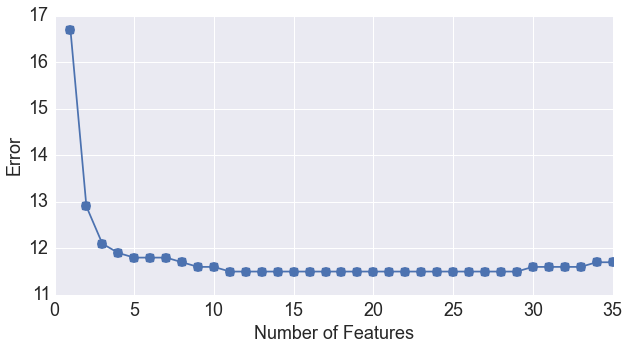

In [57]:
plot_error_vs_features(RMSE, 'none', 'none')

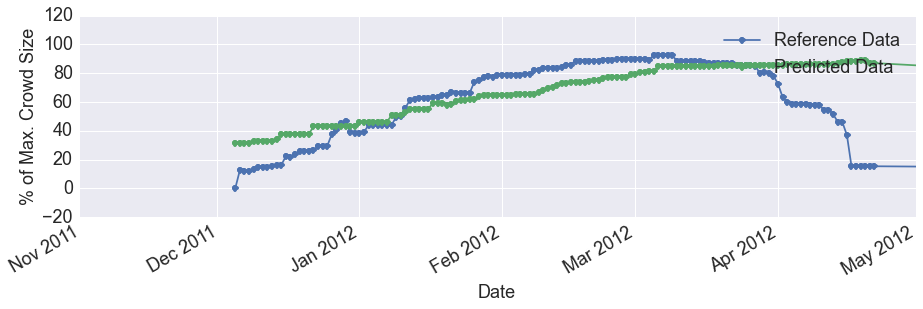

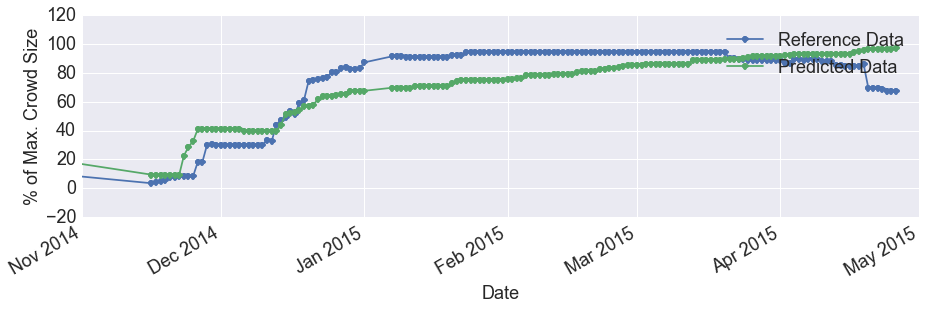

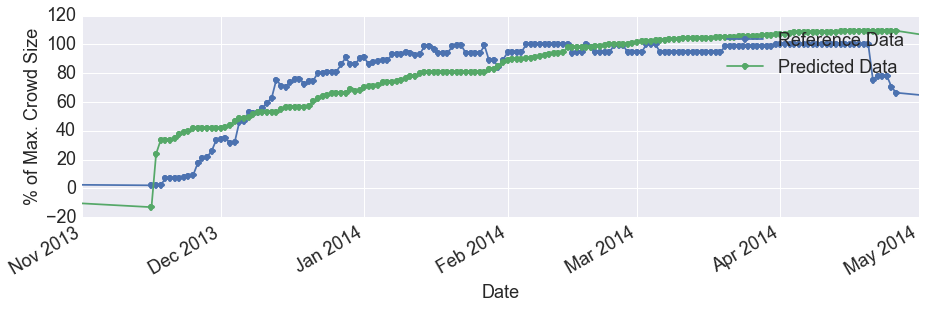

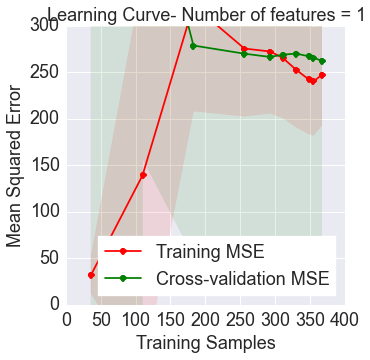

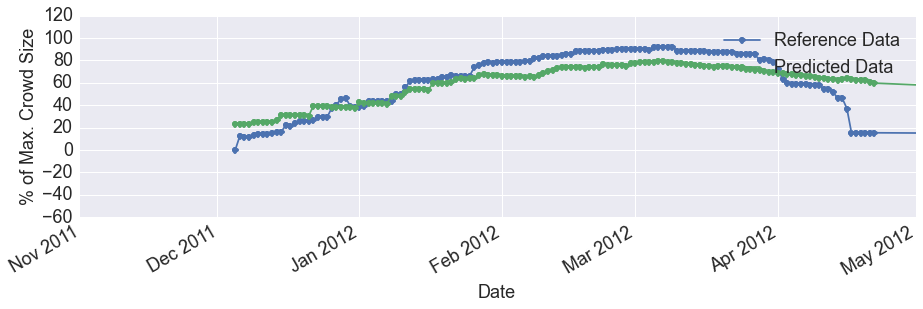

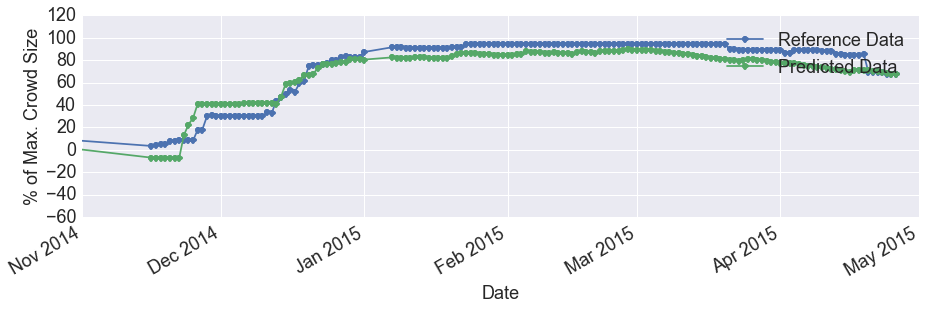

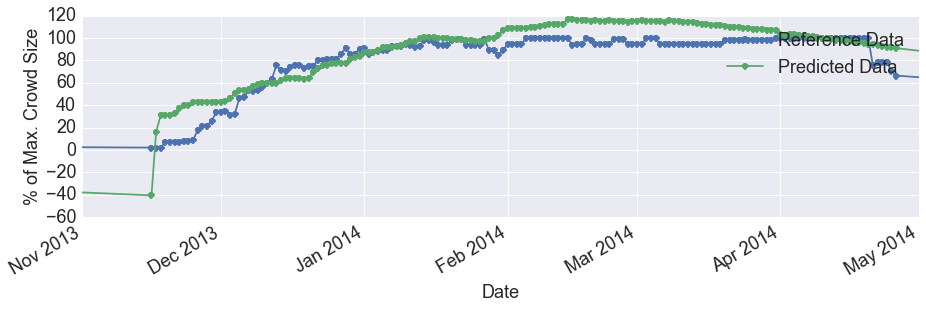

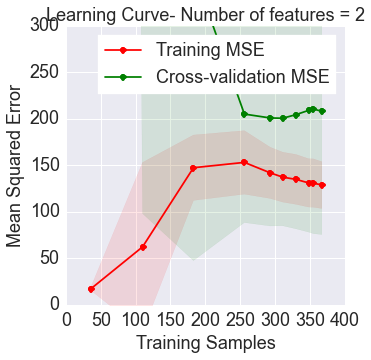

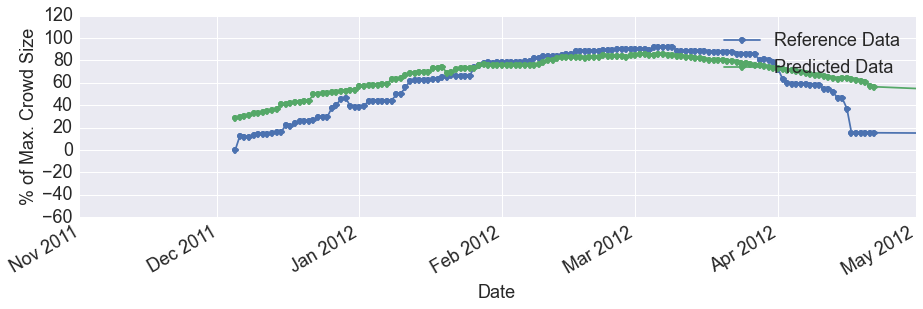

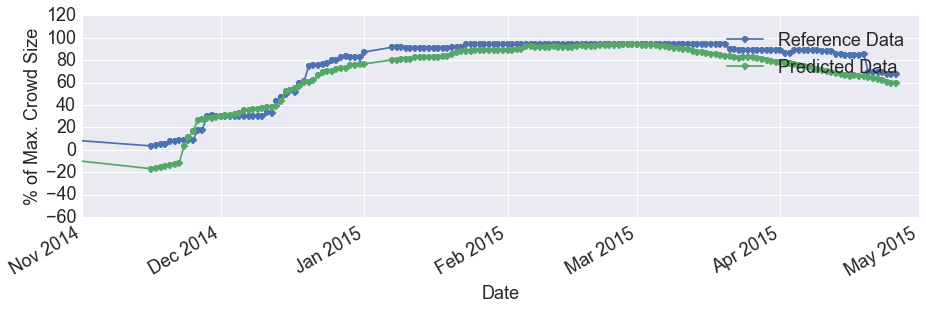

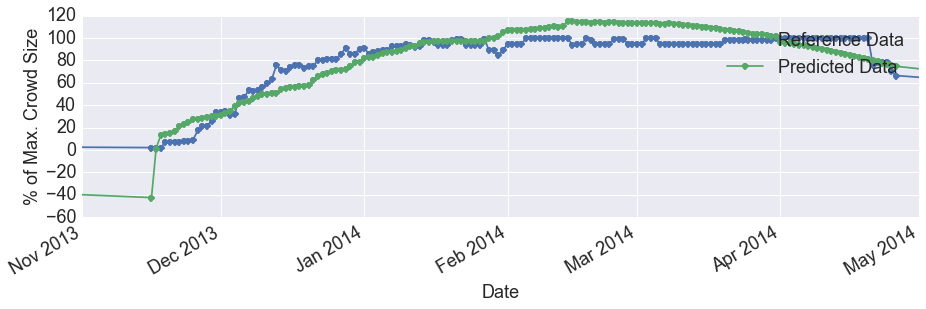

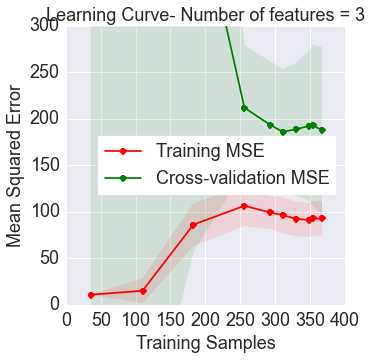

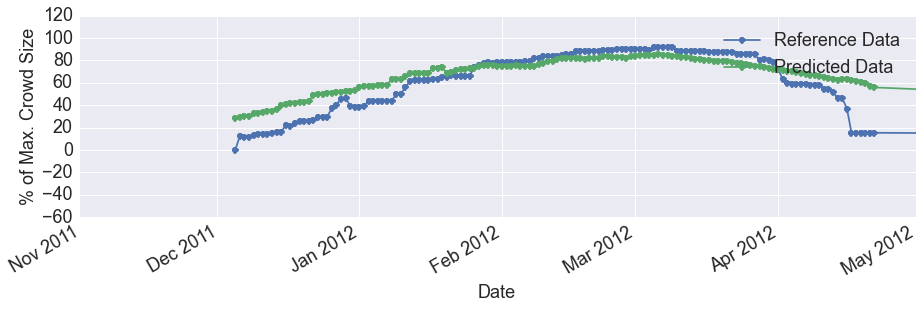

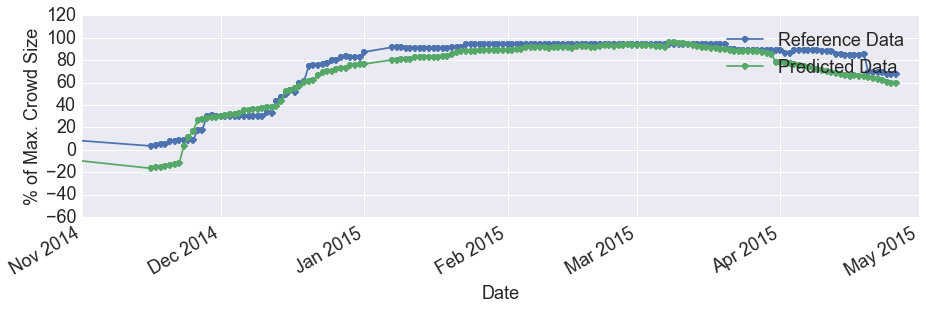

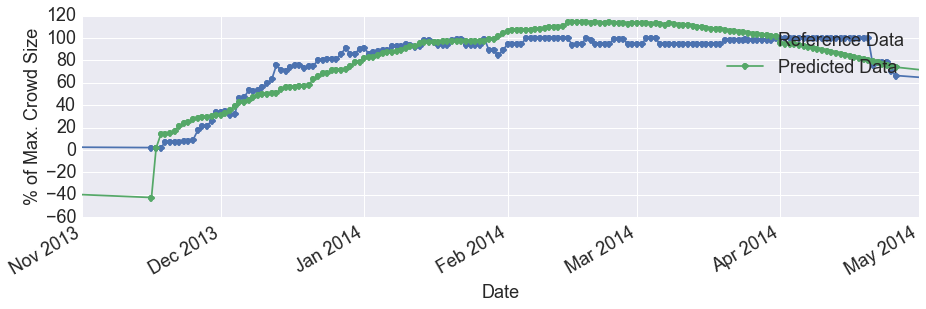

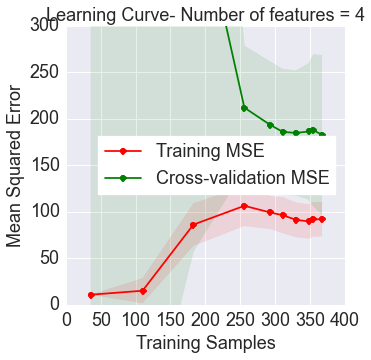

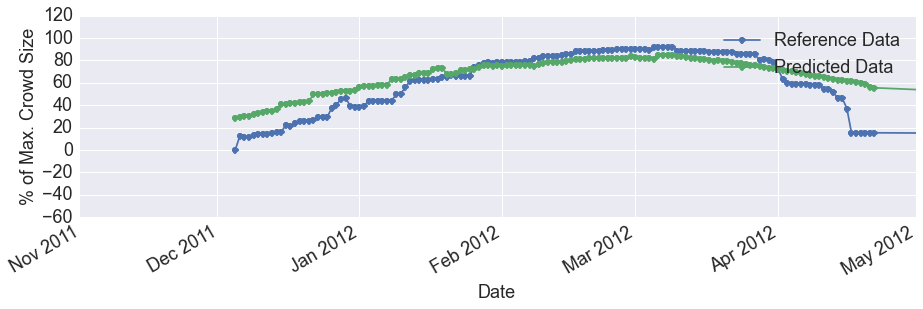

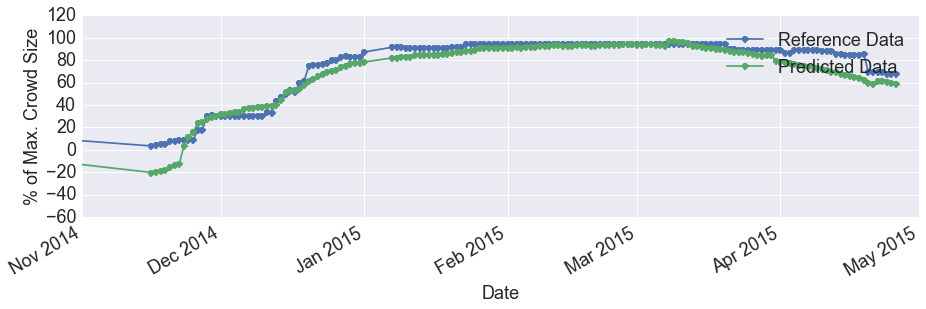

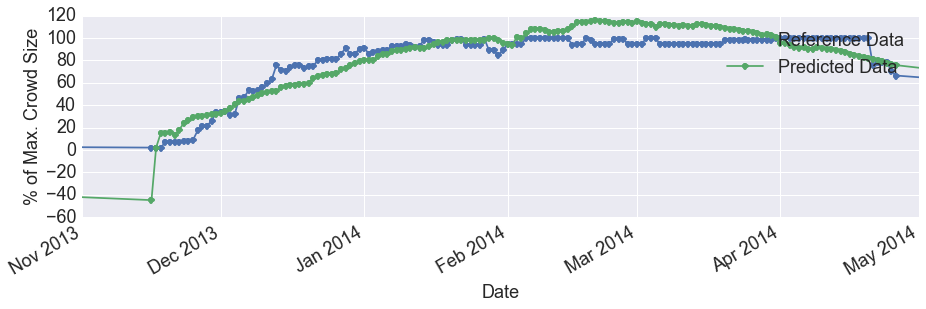

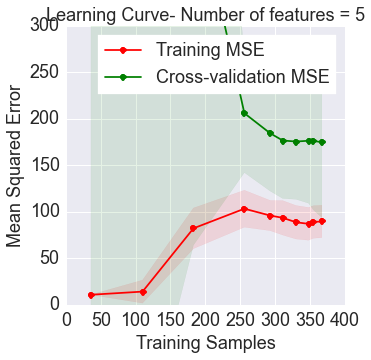

In [67]:
i = 1
while i < 6:
    num_good_feat = i
    df_reg = pd.concat([df_tr[ref_column], df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr[ref_column].values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 10)
    df_reg['pred'] = cv_pred
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], 1200, (15, 4))
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], 1200, (15,4))
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], 1200, (15,4))
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,300), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

In [73]:
num_feat = 3
best_features = fs_features[0:num_feat]
RMSE_H_lin, RMSE_CV, df_H_lin, df_cv_lin = get_holdout_RMSE(lin_regr, best_features, df_tr, df_h, ref_column)

CV RMSE: 12.1 ,  Holdout RMSE: 19.4


### Cross Validation Fit

In [77]:
ref_column

'open_trails'

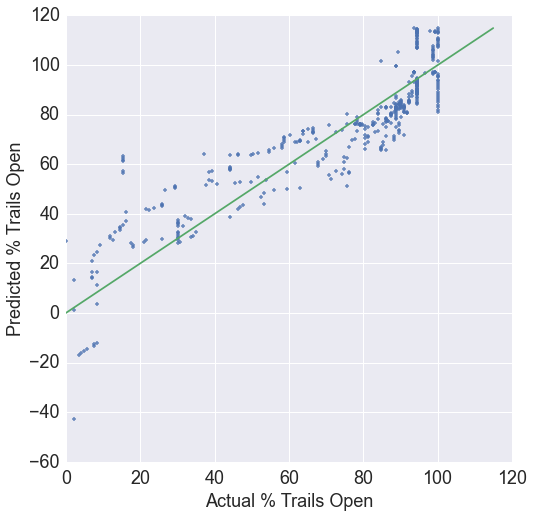

In [78]:
fitted_vs_ref_plot(df_cv_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

### Holdout Fit

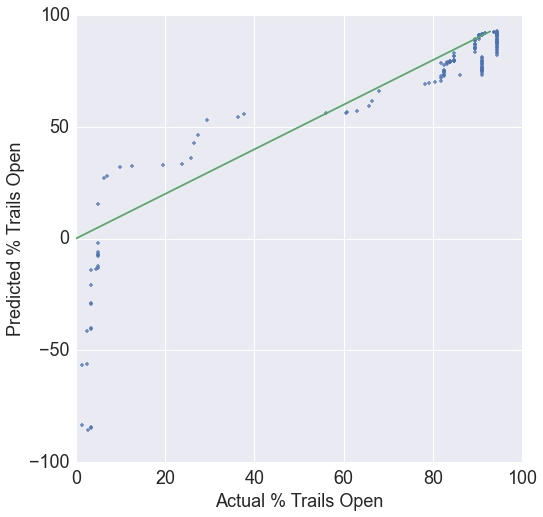

In [79]:
fitted_vs_ref_plot(df_H_lin, ref_column, 'Predicted % Trails Open', 'Actual % Trails Open')

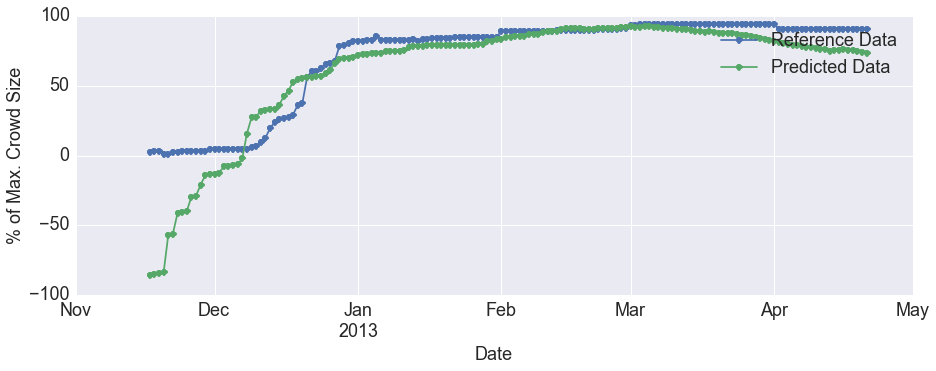

In [80]:
plot_fitted_and_ref_vs_time(df_H_lin, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE, (15,5))

In [81]:
df_H_lin['pred_low'] = df_H_lin.pred - RMSE_H_lin
df_H_lin['pred_up'] = df_H_lin.pred + RMSE_H_lin

### Lasso

In [83]:
features = list(df.columns.values)
features.remove(ref_column)

In [98]:
X_tr, y_tr, X_h, y_h = find_training_and_hold_sets(df_tr, df_h, features, ref_column)

In [99]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 1e-5, 10000000, 1.5)

Best Lambda: 10.0


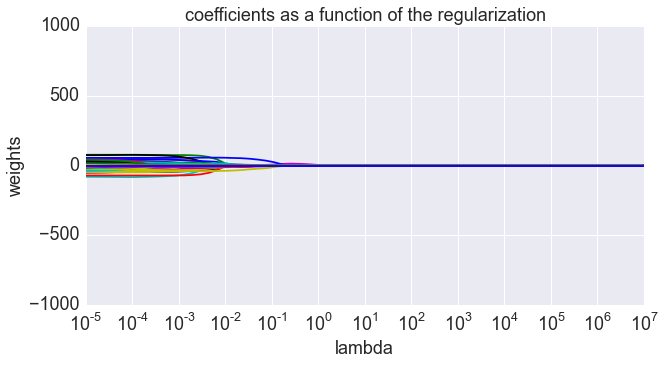

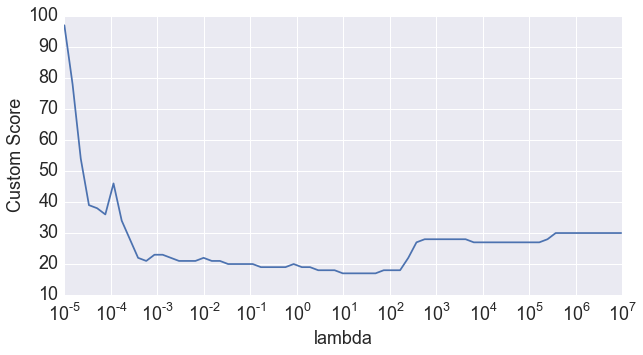

In [100]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda, (-1000,1000))

#### Find cross-validation and holdout RMSE

In [101]:
clf = linear_model.Lasso(alpha=best_lambda)

In [103]:
RMSE_ls_H, RMSE_ls_CV, df_ls_hold, df_ls_cv = get_holdout_RMSE(clf, features, df_tr, df_h, ref_column)

CV RMSE: 17.4 ,  Holdout RMSE: 10.4


#### Plot the holdout lasso prediction vs the reference data

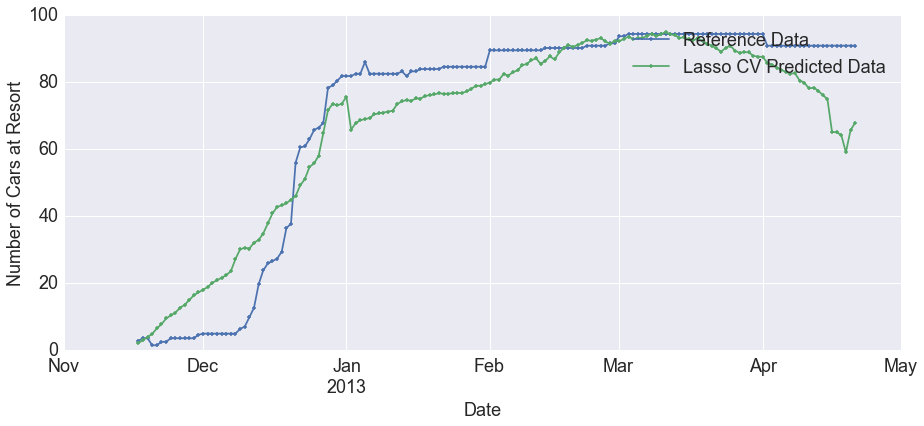

In [104]:
plot_lasso_and_ref_vs_time(df_ls_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])

## Random Forest

In [105]:
features = fs_features

In [106]:
X_tr = df_tr[features]
y_tr = df_tr[ref_column].values
X_h = df_h[features]
y_h = df_h[ref_column].values

#### Fit the random forest regressor and find cross-validation stats

In [115]:
rfr = RandomForestRegressor(n_estimators = 1000, oob_score = True, n_jobs = -1)

In [116]:
RMSE_rf_H, RMSE_rf_CV, df_rf_hold, df_rf_cv = get_holdout_RMSE(rfr, features, df_tr, df_h, ref_column)

CV RMSE: 11.4 ,  Holdout RMSE: 5.0


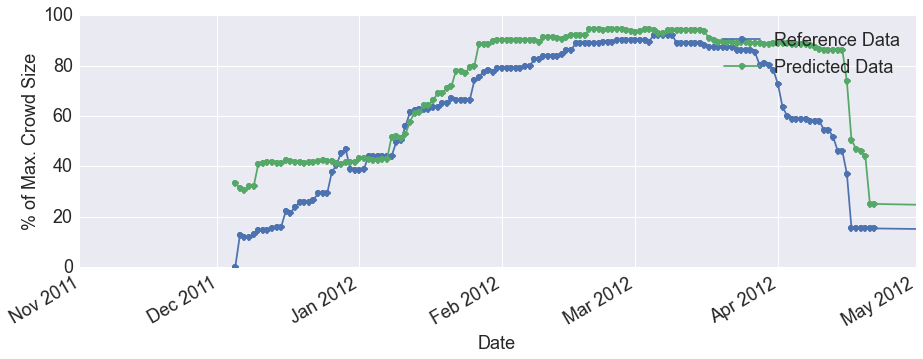

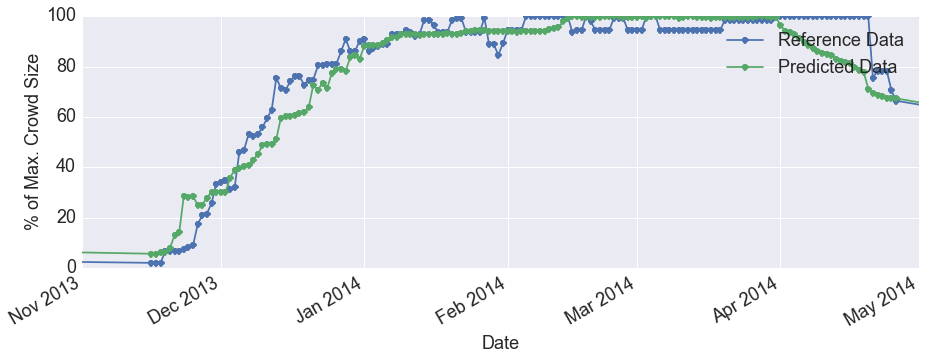

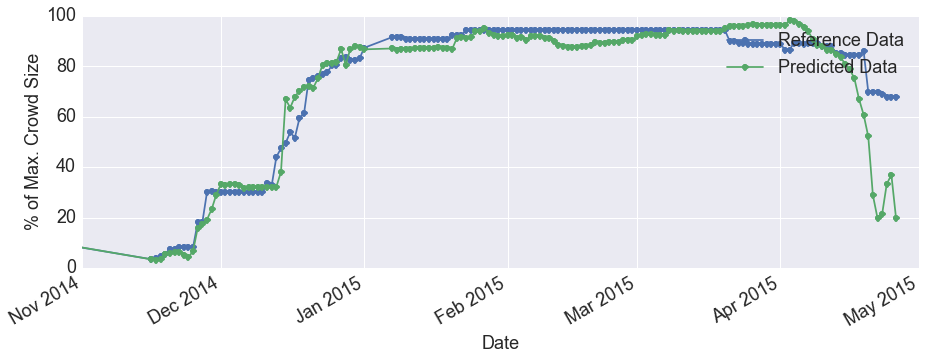

In [111]:
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'], RMSE_rf_CV, (15,5))
plot_fitted_and_ref_vs_time(df_rf_cv, ref_column, ['2014-11-1 00:00:00', '2015-05-1 00:00:00'], RMSE_rf_CV, (15,5))

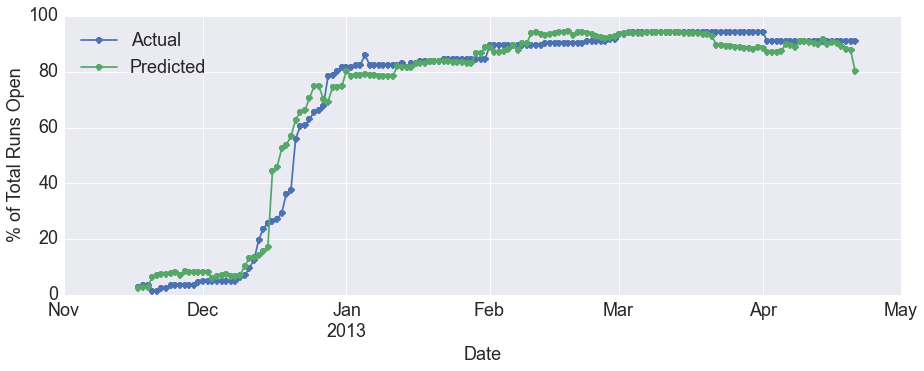

In [122]:
plot_fitted_and_ref_vs_time(df_rf_hold, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'], RMSE_rf_H, (15,5), '% of Total Runs Open')

### Export Linear Model with Best Features to Model

In [123]:
df = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2015,5,1)]
X = df[fs_features]
y = df[ref_column]
mdl = rfr.fit(X,y)

In [124]:
#saving pickle file as .p is best
pickle_out = open('../webpage_ski/rfr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [125]:
df_out = df[fs_features]

In [126]:
df_out.to_csv('../webpage_ski/df_runs_open.csv')